✅ Dataset cargado
🟦 X shape: (27000, 64, 64, 3)
🟥 y shape: (27000,)
📚 Clases: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
                      precision    recall  f1-score   support

          AnnualCrop       0.65      0.70      0.67       600
              Forest       0.84      0.90      0.87       600
HerbaceousVegetation       0.61      0.55      0.58       600
             Highway       0.51      0.29      0.37       500
          Industrial       0.71      0.88      0.78       500
             Pasture       0.70      0.83      0.76       400
       PermanentCrop       0.46      0.39      0.42       500
         Residential       0.54      0.65      0.59       600
               River       0.66      0.65      0.65       500
             SeaLake       0.95      0.89      0.92       600

            accuracy                           0.67      5400
           macro avg       0.66      0.

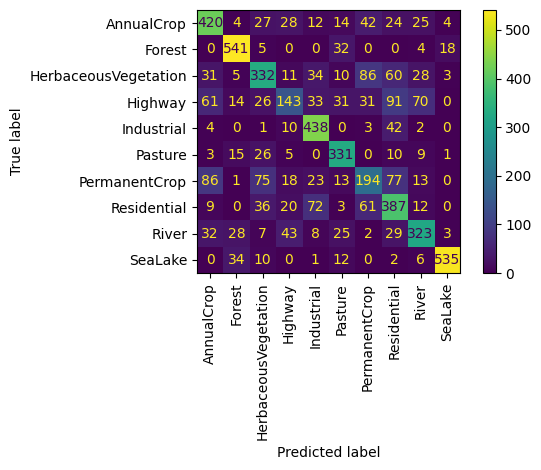

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


import sys
import os

# Ruta absoluta a la carpeta raíz (donde está la carpeta "scripts")
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Subís un nivel
sys.path.append(root_path)

from datasets.cargar_eurosat import cargar_dataset_eurosat

# Cargar imágenes y etiquetas
X, y, clases = cargar_dataset_eurosat("../datasets/EuroSAT")

print("✅ Dataset cargado")
print("🟦 X shape:", X.shape)
print("🟥 y shape:", y.shape)
print("📚 Clases:", clases)

# Aplanar imágenes para usar modelo clásico
X_flat = X.reshape((X.shape[0], -1))

# Split
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, stratify=y, random_state=42)

# Modelo baseline
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluación
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=clases))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=clases, xticks_rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from sklearn.decomposition import PCA

# Agregamos la ruta raíz para importar módulos personalizados
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_path)

from scripts.pc_smote import PCSMOTE  # Asegurate de que está en la carpeta scripts


# Cargar EuroSAT
from datasets.cargar_eurosat import cargar_dataset_eurosat
X, y, clases = cargar_dataset_eurosat("../datasets/EuroSAT")
print(f"📦 Dataset EuroSAT cargado: X={X.shape}, y={y.shape}")

# Aplanar imágenes para usar modelos clásicos
X_flat = X.reshape((X.shape[0], -1))

# Separar conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, stratify=y, random_state=42)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Técnicas de sobremuestreo
tecnicas = {
    "SMOTE": SMOTE(random_state=42),
    # "ADASYN": ADASYN(random_state=42),
    "BorderlineSMOTE": BorderlineSMOTE(random_state=42),
    "PC-SMOTE": PCSMOTE(random_state=42, percentil_densidad=50, modo_espacial='3d')
}

# Modelos a evaluar
modelos = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    # "SVM": SVC(),
    # "KNN": KNeighborsClassifier(n_neighbors=5),
    # "SVM": SVC(kernel='rbf', probability=True),
    # "GradientBoosting": GradientBoostingClassifier()    
}

# Evaluar cada combinación
for nombre_tecnica, sampler in tecnicas.items():
    print(f"\n🚀 Técnica de sobremuestreo: {nombre_tecnica}")

    if hasattr(sampler, "fit_resample_multiclass"):
        X_res, y_res = sampler.fit_resample_multiclass(X_train_pca, y_train)
    else:
         X_res, y_res = sampler.fit_resample(X_train_pca, y_train)

    for nombre_modelo, modelo in modelos.items():
        print(f"\n⚙️ Clasificador: {nombre_modelo}")
        modelo.fit(X_res, y_res)
        y_pred = modelo.predict(X_test_pca)

        print(classification_report(y_test, y_pred, target_names=clases))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=clases, xticks_rotation=45)
        plt.tight_layout()
        plt.show()

